In [29]:
import os
import sys
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

In [95]:
root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/'
# root_dir = '/data/jupiter/datasets/20230823_labeled_right_images_12k'
# root_dir = '/data/jupiter/li.yu/data/left_and_right_labels_samples'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2022_Dust_Humans_Unfiltered_partiallabeled'
# dataset = 'Jupiter_train_v6_2'
dataset = 'Jupiter_train_v6_2_birds_airborne_debris'
# dataset = 'halo_rgb_stereo_train_v6_1'
# dataset = 'halo_rgb_stereo_test_v6_1'
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
# csv = os.path.join(root_dir, 'v61base_epoch0_5_30_focal05_master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

(16894, 424)

5f91d0d0fee8840172271ed8 side-right-left


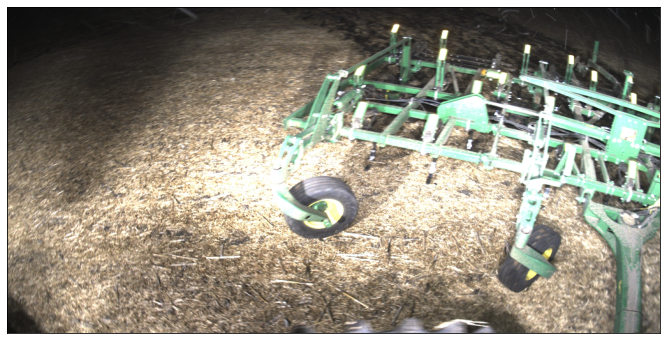

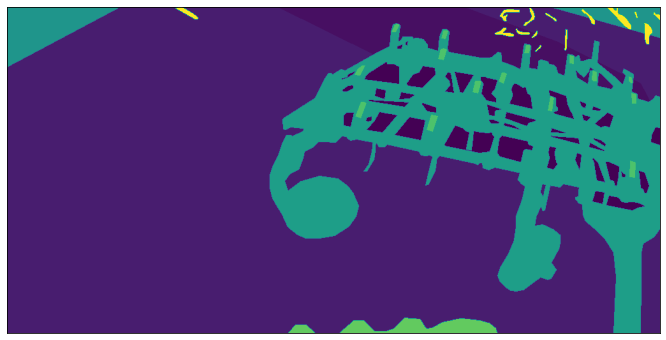

In [100]:
# sub_df = df2[df2.camera_pod == 'implement_pod'].sample(5)
# sub_df = df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].sample(2)
# sub_df = df[df.unique_id == '64d6542284dac3a508c73ae0_T14_T15']
sub_df = df.sample(1)
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
show_image, show_label = False, False
show_debayered_rgb, show_raw_label = True, True
show_pred_result = False
for i, row in sub_df.iterrows():
    # print(row.id, row.gt_dust_ratio, row.pred_dust_ratio)
    print(row.id, row.camera_location)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        plot_image(label)

    if show_pred_result:
        result_path = os.path.join(pred_dir, 'output_visualization', row.id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

In [101]:
image.shape, label.shape

((512, 1024, 3), (512, 1024))

## Check and create new csv

In [15]:
# load cutnpaste columns
# df2 = pd.read_parquet('/data2/jupiter/datasets/Jupiter_train_v6_2/cache/cutnpaste_961706335.parquet')
df2 = pd.read_csv('/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1/cache/cutnpaste_1553242183.csv')
df2.shape

(147222, 344)

In [16]:
set(df2.columns) - set(df.columns)

{'brightness',
 'color_transfer_npz_save_path',
 'humans_max_col',
 'humans_max_row',
 'humans_min_col',
 'humans_min_row',
 'humans_pixel_count',
 'is_humans_present_in_annotations',
 'is_laying_down_human',
 'is_multi_human',
 'is_standing_human',
 'is_tractors_or_vehicles_present_in_annotations',
 'label_counts',
 'occluded_humans',
 'tractors_or_vehicles_max_col',
 'tractors_or_vehicles_max_row',
 'tractors_or_vehicles_min_col',
 'tractors_or_vehicles_min_row',
 'tractors_or_vehicles_pixel_count'}

In [4]:
df2['is_humans_present_in_annotations'] = df2['humans_pixel_count'] > 0
df2['is_tractors_or_vehicles_present_in_annotations'] = df2['tractors_or_vehicles_pixel_count'] > 0
print(df2.columns)
common_columns = ['brightness', 'label_counts', 
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations']
common_columns = set(common_columns).intersection(list(df.columns))
# drop columns in df
df.drop(common_columns, axis=1, inplace=True)
print(df.shape)
df1 = df.merge(df2, on='unique_id')
print(df1.shape)

Index(['brightness', 'label_counts', 'Airborne-debris', 'Driveable',
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col', 'unique_id',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations'],
      dtype='object')
(318874, 416)
(318874, 436)


In [13]:
# update stereo_pipeline_npz_save_path with clean depth
df2 = pd.read_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean.csv')
print(df2.shape)
df1.drop(columns=['stereo_pipeline_npz_save_path'], axis=1, inplace=True)
print(df1.shape)
df1 = df1.merge(df2[['id', 'stereo_pipeline_npz_save_path']], on='id')
print(df1.shape)
df1.to_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean_fl05.csv', index=False)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7,8,40,59,60,61,62,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,110,111,112,113,115,116,117,118,119,120,121,122,123,124,125,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,161,162,163,164,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,183,184,185,186,187,188,189,190,191,192,193,224,226,228,231,248,252,255,256,262,263,264,268,309,320,325,327,328,338,339,347,355,371,372,374,375,377,378) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(321638, 425)
(318874, 435)
(318874, 436)


In [15]:
# df2['stereo_pipeline_npz_save_path'] = df2['stereo_pipeline_npz_save_path'].apply(lambda p: p[43:])
# df2['rectified_label_save_path'] = df2['rectified_label_save_path'].apply(lambda p: p[43:])
# df2 = df2.drop('color_transfer_npz_save_path', axis=1)
# df2.iloc[0].stereo_pipeline_npz_save_path, df2.iloc[0].rectified_label_save_path

('processed/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz',
 'processed/images/614d0eb90f7787d7ba7d1e43/rectification_output_61dd087a50a352ea47e1e4b4.npz')

## Get categorical labels for training set

In [48]:
categorical_labels_map = {'objects': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 'humans': {'Humans'}, 
                            'vehicles': {'Tractors or Vehicles'}, 'dust': {'Heavy Dust'}, 'birds': {'Birds'}, 'airborne': {'Airborne Debris'}}
cats = list(categorical_labels_map.keys())
categorical_object_labels = {v for k,vs in categorical_labels_map.items() for v in vs}
cats, categorical_object_labels

(['objects', 'humans', 'vehicles', 'dust', 'birds', 'airborne'],
 {'Airborne Debris',
  'Animals',
  'Birds',
  'Buildings',
  'Heavy Dust',
  'Humans',
  'Immovable Objects',
  'Tile-Inlet',
  'Tractors or Vehicles',
  'Utility pole'})

In [34]:
def get_categorical_labels(root_dir, dataset, row):
    label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
    labels = np.unique(label)
    label_map = row.label_map
    label_str_2_id = {label_map[str(i)]: i for i in labels if i != 0}
    # print(row.unique_id, label.shape, labels, label_str_2_id)
    # process object class
    for object_label, subs in categorical_labels_map.items():
        object_ids = [label_str_2_id[sub] for sub in subs if sub in label_str_2_id]
        object_pixel_count = 0
        if len(object_ids) > 0:
            object_pixel_count = np.count_nonzero(np.isin(label, object_ids))
        row[object_label] = object_pixel_count
    return row

# get_categorical_labels(root_dir, dataset, df.iloc[100])

In [44]:
# df = df.apply(lambda row: get_categorical_labels(root_dir, dataset, row), axis=1)
# print(df.shape)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv', index=False)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv', index=False)
# df[['unique_id'] + cats].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv', index=False)

(16894, 430)


In [49]:
count_df = pd.read_csv('/data/jupiter/li.yu/data/Jupiter_train_v6_2/train_v6_2_birds_airborne_categorical_count.csv')
# count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv')
# count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/test_v6_1_categorical_count.csv')
# count_df = df[['unique_id'] + cats]
print(count_df.shape)
count_df.head(2)

(16894, 7)


,unique_id,objects,humans,vehicles,dust,birds,airborne
0,61bb1d2cf2f41a5e36668d0d,5275,0,0,0,35,0
1,63c78dbeceb286e53e9b3031,647,0,0,0,0,800


In [61]:
categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 50], ['airborne', 50]]
for cat, thres in categorical_labels:
    cat_count_df = count_df[count_df[cat] > thres]
    print(f'{cat}: # images {len(cat_count_df)}, {len(df) / len(cat_count_df):.1f}, quantile 90% pixel count {cat_count_df[cat].quantile(q=0.9):.0f}')
    # cat_count_df[cat].hist(bins=100)
    # plt.show()

objects: # images 7665, 2.2, quantile 90% pixel count 3800
humans: # images 159, 106.3, quantile 90% pixel count 13931
vehicles: # images 303, 55.8, quantile 90% pixel count 15180
dust: # images 6254, 2.7, quantile 90% pixel count 164159
birds: # images 1718, 9.8, quantile 90% pixel count 4697
airborne: # images 14845, 1.1, quantile 90% pixel count 9649


In [13]:
pred_csv1 = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_dustaugonhuman_dlbase_0109/halo_rgb_stereo_test_v6_1_640/output.csv'
pred_csv2 = '/data/jupiter/li.yu/exps/driveable_terrain_model/v61_7cls_dustaugonhuman_dlbase_0109/halo_rgb_stereo_test_v6_1_768/output.csv'
pred_df = pd.concat([pd.read_csv(pred_csv1), pd.read_csv(pred_csv2)], ignore_index=True)
print(pred_df.shape)
pred_df.head(1)

(50864, 11)


,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,state,human_state,vehicle_state,min_pixels_threshold,features
0,64cfde4981c0f0db5eaa1f29_T02_T03,64cfde4981c0f0db5eaa1f29,T02,daytime,first headland pass,s3://blueriver-jupiter-data/continuous/halohit...,true_negative,NaN,NaN,72,"{""large_object_pixels"": 0, ""large_object_min_r..."


In [15]:
def get_results(count_df, res_df, binary_category=True, only_2cls=True):
    print(f'category gt_count pred_count matched')
    if binary_category:
        if only_2cls:
            categorical_labels = [['birds', 50], ['airborne', 50]]
        else:
            categorical_labels = [['objects', 50], ['humans', 50], ['vehicles', 200], ['dust', 1000], ['birds', 50], ['airborne', 50]]
        for cat, thres in categorical_labels:
            cat_count_df = count_df[count_df[cat] > thres]
            cat_res_df = res_df[res_df[cat] > 0.5]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))
    else:
        if only_2cls:
            categorical_labels = [['birds', 2256], ['airborne', 5477]]
        else:
            categorical_labels = [['objects', 24664], ['humans', 31081], ['vehicles', 131716], ['dust', 360000], ['birds', 2256], ['airborne', 5477]]
        percent_thres = 0.005
        for cat, thres in categorical_labels:
            cat_count_df = count_df[(count_df[cat] / thres) > percent_thres]
            cat_res_df = res_df[res_df[cat] > percent_thres]
            cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
            print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df))

In [18]:
run_ids = [
    # 'v61_6cls_cat_0119',
    # 'v61_6cls_cat_0120',
    'v61_6cls_posw_cat_0120',
    # 'v61_2cls_bin_cat_0122',
    # 'v61_6cls_np90_cat_0120',
    # 'v61_6cls_np90_posw_cat_0120',
    # 'v61_6cls_np90_cap_posw_cat_0120',
]
for run_id in run_ids:
    print(run_id)
    res_df = pd.read_csv(f'/data/jupiter/li.yu/exps/driveable_terrain_model/{run_id}/halo_rgb_stereo_test_v6_1/output.csv')
    get_results(count_df, res_df, binary_category = not 'np90' in run_id, only_2cls=False)
    print()

v61_6cls_posw_cat_0120
category gt_count pred_count matched
objects 38270 41483 35459
humans 16346 11955 11191
vehicles 8386 10113 5125
dust 4523 4843 3516
birds 1478 622 526
airborne 1923 2044 689



In [21]:
cat = 'birds'
cat_count_df = count_df[count_df[cat] > thres]
cat_res_df = res_df[res_df[cat] > 0.5]
cat_pred_df = pred_df[pred_df.state == 'true_positive']
cat_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_res_df.unique_id)]
cat_pred_correct_df = cat_count_df[cat_count_df.unique_id.isin(cat_pred_df.unique_id)]
print(cat, len(cat_count_df), len(cat_res_df), len(cat_correct_df), len(cat_pred_df), len(cat_pred_correct_df))

birds 1478 622 526 5297 709
